# OptOut Project: Sample Selection

* Construct Extended Sample: biological mothers who lived until their first child’s 18th birthday
* Construct 14-year-sequence Sample: capture a larger sample by analyzing 14 years of maternal employment for robustness chek
* Dataset: NLSY79 (1979-2014)

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
from collections import defaultdict
from dateutil.relativedelta import relativedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Start from the entire NLSY79 sample

In [2]:
#read birth data
dob_df = pd.read_csv('../data/childbirth.csv')
print dob_df.shape
dob_df.head()

(12686, 26)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c7dob_m_xrnd,c7dob_y_xrnd,c8dob_m_xrnd,c8dob_y_xrnd,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,3,1,5,1989,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [3]:
#drop males
#1-male; 2-female
sample_df = dob_df[dob_df.sample_sex_1979==2]
print sample_df.shape

(6283, 26)


In [4]:
#drop subsamples that weren’t followed over the entire survey period
print 'subsamples before dropping:', sample_df.sample_id_1979.unique()
sample_df = sample_df[(~sample_df.sample_id_1979.isin([9, 12, 15, 16, 17, 18, 19, 20]))]
print 'subsamples after dropping:', sample_df.sample_id_1979.unique()
print sample_df.shape

subsamples before dropping: [ 5  6  8  7 14 12 13 18 19 20]
subsamples after dropping: [ 5  6  8  7 14 13]
(4926, 26)


There are 4926 women in NLSY79.

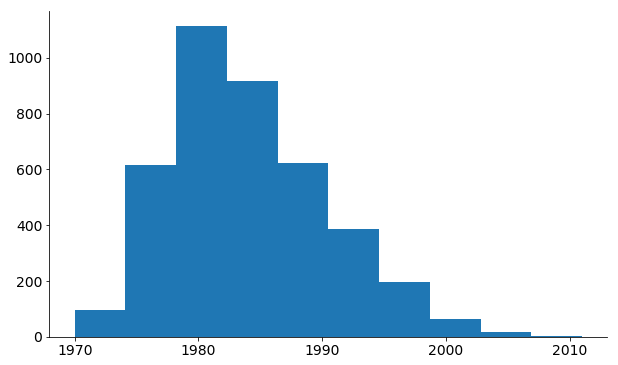

In [5]:
#distribution of child birth dates
plt.hist(sample_df.c1dob_y_xrnd[sample_df.c1dob_y_xrnd!=-4])
remove_border()

### Respondents's date of birth

In [6]:
# read data
dob_df = pd.read_csv('../data/dob.csv')
dob_df.head()

,caseid_1979,m_dob_1979,y_dob_1979,m_dob_1981,y_dob_1981
0,1,9,58,9,58
1,2,1,59,1,59
2,3,8,61,-5,-5
3,4,8,62,8,62
4,5,7,59,7,59


In [7]:
#is there missing dob reported in 1979? NO
missing79 = []
for i, row in dob_df.iterrows():
    if row['m_dob_1979']<=0 or row['y_dob_1979']<=0: 
        missing79.append(row)

print len(missing79)

0


In [8]:
#verify if dob reported in 1979 is the same as dob reported in 1981
diff= []
missing81 = []
for i, row in dob_df.iterrows():
    if row['m_dob_1981']>0 and row['y_dob_1981']>0: #if it's valid dob in 1981
        if row['m_dob_1979']!=row['m_dob_1981'] or row['y_dob_1979']!=row['y_dob_1981']:
            diff.append(row)
    else:
        missing81.append(row)

print '%s respondents had missing dob in 1981 survey'%len(missing81)
print '%s respondents had valid, but different (from 1979) dob in 1981 survey'%len(diff)

491 respondents had missing dob in 1981 survey
263 respondents had valid, but different (from 1979) dob in 1981 survey


In [9]:
# how are dob different in 1979 and 1981 (just show the first 15 cases)
# show the first 15 cases

i = 0
print '1979 birth month | year | 1981 birth month | year'
for row in diff:
    print row.values[1:]
    i += 1
    
    if i>=15:
        break

1979 birth month | year | 1981 birth month | year
[ 1 59 11 59]
[11 63  9 63]
[12 57 12 59]
[ 9 62  9 63]
[ 6 64  6 65]
[ 6 57  7 57]
[ 9 63  5 63]
[ 9 58 11 58]
[ 4 63  5 63]
[ 3 60  4 60]
[ 5 58  9 58]
[ 3 63  7 62]
[ 6 58  5 58]
[ 7 64  4 64]
[ 5 58  4 58]


Some people reported different birth months and some reported different birth years. **DECISION: USE DOB REPORTED IN 1979.**

In [10]:
# use dob reported in 1979. What are the unique birth years present in the dataset?
dob_df.y_dob_1979.unique()

array([58, 59, 61, 62, 60, 64, 63, 57])

In [11]:
# add birth year and birth month
sample_df = sample_df.merge(dob_df[['caseid_1979', 'y_dob_1979', 'm_dob_1979']], on='caseid_1979')

# rename
sample_df = sample_df.rename(index=str, columns={"y_dob_1979": "y_dob", "m_dob_1979":"m_dob"})

In [12]:
# add 1900 to dob year
sample_df.y_dob = sample_df.y_dob.map(lambda x: x+1900)

In [13]:
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c8dob_m_xrnd,c8dob_y_xrnd,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd,y_dob,m_dob
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,1958,9
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,1959,1
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,-4,-4,1961,8
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,1962,8
4,8,6,3,2,3,1976,5,1979,9,1982,...,-4,-4,-4,-4,-4,-4,-4,-4,1958,7


### Survey year and month

In [14]:
intdate_df = pd.read_csv('../data/int_date.csv')
intdate_df.head()

,caseid_1979,date_m_1979,date_d_1979,date_m_1980,date_d_1980,date_m_1981,date_d_1981,date_m_1982,date_d_1982,date_m_1983,...,date_y_2008,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014
0,1,3,3,-5,-5,6,25,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,2,28,3,3,2,23,2,6,2,...,2008,10,3,2010,3,12,2012,26,12,2014
2,3,2,8,5,20,-5,-5,3,11,3,...,2008,-5,-5,-5,19,3,2013,8,5,2015
3,4,2,8,-5,-5,3,24,3,3,1,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,4,19,4,3,3,12,3,1,4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [15]:
sample_df = sample_df.merge(intdate_df, on='caseid_1979')

### Determine last valid year and deceased year from reasons for non-interview variables 

In [16]:
#read reson-for-non-interview data
rni_df = pd.read_csv('../data/reasonnonint.csv')
rni_df.head()

,caseid_1979,rni_1980,rni_1981,rni_1982,rni_1983,rni_1984,rni_1985,rni_1986,rni_1987,rni_1988,...,rni_1996,rni_1998,rni_2000,rni_2002,rni_2004,rni_2006,rni_2008,rni_2010,rni_2012,rni_2014
0,1,61,-4,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
1,2,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,-4,61,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,64,-4,-4,61,-4,-4
3,4,66,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,61,61,64,61,66,61,61,61
4,5,-4,-4,-4,-4,-4,61,-4,67,-4,...,61,61,61,72,61,61,61,61,61,61


In [17]:
#how many women decreased during the course of surveys?

deceased = {} # dictionary to store {id: year deceased}

sample = sample_df.caseid_1979.values.tolist() #save respondent Ids in a list 

for i in sample: #iterate through the sample
    
    #find the row in reason-noninterview dataframe that corresponds to the given id
    row = rni_df[rni_df.caseid_1979==i].iloc[0]
    
    #get a list of rni values, not counting the first variable caseid
    vals = row.values.tolist()[1:]
  
    if 65 in vals:
        #derive death year from column name
        col_name = row.index[vals.index(65)+1] #because vals is defined starting from index 1
        deceased[i] = int(col_name[-4:]) 
        
print '%s respondents passed away during the period of study'%len(deceased.keys())

296 respondents passed away during the period of study


In [18]:
#for exmaple, in format (id, year decased)
deceased.items()[:10]

[(1025, 2012),
 (3074, 2004),
 (4099, 2010),
 (1540, 2014),
 (4182, 2014),
 (7681, 2006),
 (1544, 2000),
 (6828, 2008),
 (5634, 2006),
 (1550, 1985)]

1980 2014


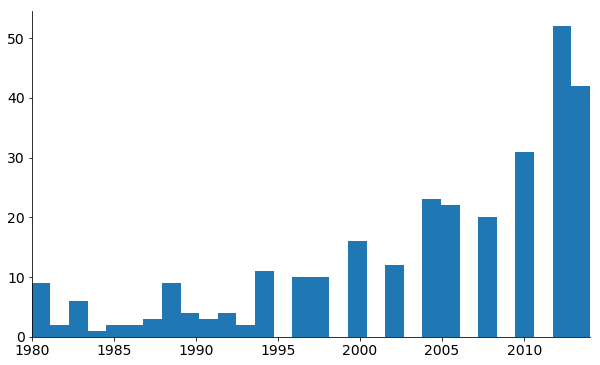

In [19]:
#distribution of the years in which respondents deceased
print min(deceased.values()), max(deceased.values())
plt.hist(deceased.values(), bins=30)
plt.xlim(min(deceased.values()), max(deceased.values()))
remove_border()

In [20]:
#add column year of death
sample_df['y_deceased'] = [deceased.get(i) for i in sample]
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014,y_deceased
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,NaN
1,2,5,3,2,3,1993,11,1994,-4,-4,...,10,3,2010,3,12,2012,26,12,2014,NaN
2,3,5,3,2,6,1981,10,1983,4,1986,...,-5,-5,-5,19,3,2013,8,5,2015,NaN
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,NaN
4,8,6,3,2,3,1976,5,1979,9,1982,...,20,12,2009,8,10,2012,6,1,2015,NaN


In [21]:
#determine last valid year
#last valid year is the year after which all rni stopped being -4
#-4 means the respondent was valid skip, i.e. interviewed
last_yr = []

for i in sample: #iterate through the sample

    #find the row in reason-noninterview dataframe that corresponds to the given id
    row = rni_df[rni_df.caseid_1979==i].iloc[0]
    
    # remove the first variable caseid_1979
    vals = row.values.tolist()[1:] 
    
    # find the last index -4 appeared
    if not -4 in vals: # respondent stopped participating since 1980, so last valid year is 1979
        last_yr.append(1979)
        
    else:
        last_ind = len(vals) - 1 - vals[::-1].index(-4) # last index at which -4 appeared
        
        #get the survey year from the variable name
        col_name = row.index[last_ind+1] # +1 because first variable caseid_1979
        last_yr.append(int(col_name[-4:]))
    
    
print set(last_yr)

set([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014])


In [22]:
#add last valid year as a new column to sample_df
sample_df['last_yr'] = last_yr
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014,y_deceased,last_yr
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,NaN,1981
1,2,5,3,2,3,1993,11,1994,-4,-4,...,3,2010,3,12,2012,26,12,2014,NaN,2014
2,3,5,3,2,6,1981,10,1983,4,1986,...,-5,-5,19,3,2013,8,5,2015,NaN,2014
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,NaN,1998
4,8,6,3,2,3,1976,5,1979,9,1982,...,12,2009,8,10,2012,6,1,2015,NaN,2014


In [23]:
#distribution of last valid year
sample_df.last_yr.value_counts()

2014    3656
2012     234
2010     149
2008     114
1998      99
2000      93
2004      75
2002      69
2006      61
1996      52
1994      52
1993      37
1989      26
1988      23
1991      23
1979      23
1987      18
1990      18
1992      18
1983      18
1984      18
1985      13
1982      12
1986      12
1981       7
1980       6
Name: last_yr, dtype: int64

In [24]:
def attr_before40(row):
    """
    Return True if respondent left study before turning age 40.
    Return False otherwise. 
    
    NEW: determined using month
    """
    
    # it's last valid year, so everyone has a valid interview month in the year
    if row['last_yr'] < 1993:
        last_survey_dt = datetime.datetime(int(row['last_yr']), int(row['date_m_%s'%int(row['last_yr'])]), 1)
    else:
        y = int(row['date_y_%s'%int(row['last_yr'])])
        if y < 1900:
            y += 1900
        last_survey_dt = datetime.datetime(y, int(row['date_m_%s'%int(row['last_yr'])]), 1)
        
    birth_dt = datetime.datetime(int(row['y_dob']), int(row['m_dob']), 1)
    diff_in_years = relativedelta(last_survey_dt, birth_dt).years
    return (diff_in_years < 40)

sample_df['attr_before40'] = sample_df.apply(attr_before40, axis=1)
sample_df.attr_before40.value_counts()

False    4396
True      530
Name: attr_before40, dtype: int64

In [25]:
# there is no month for deceased date. it is always -5
# I don't think it helps to look at the interview date from the previous survey wave 
# because we'll get the same result from year alone

def deceased_before40(row):
    """Return True if respondent deceased before age 40."""
    
    if not np.isnan(row['y_deceased']): #if respondent deceased
        return row['y_deceased'] < row['y_dob']+40
    return False

sample_df['deceased_before40'] = sample_df.apply(deceased_before40, axis=1)
sample_df.deceased_before40.value_counts()

False    4846
True       80
Name: deceased_before40, dtype: int64

### Categories of respondents

In [26]:
#total number of female respondents
print sample_df.shape[0]

4926


In [27]:
count = defaultdict(int)

for i, row in sample_df.iterrows():
    
    if row['attr_before40']==True and row['deceased_before40']==True:
        count['attr, deceased'] += 1
        
    elif row['attr_before40']==True and row['deceased_before40']==False:
        count['attr, not deceased'] += 1
        
    elif row['attr_before40']==False and row['deceased_before40']==True: # impossible
        count['not attr, deceased'] += 1
        
    elif row['attr_before40']==False and row['deceased_before40']==False:
        count['not attr, not deceased'] += 1
        
print count

defaultdict(<type 'int'>, {'not attr, not deceased': 4396, 'attr, not deceased': 450, 'attr, deceased': 80})


In [28]:
#how many childless women who are observed through age 40?
#these women remained childless until the end of their reproductive years

print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before40==False)].shape[0]
print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before40==False)&(sample_df.deceased_before40==False)].shape[0]

692
692


In [35]:
df = sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before40==False)]
df.to_csv('../data/childless_df.csv', index=False)

In [29]:
#childless women who deceased before age 40
#These women could have had children, but were unobserved

#We need to find whether the women remained childless until the end of their reproductive years or their death, 
#whichever came first 
 
print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.deceased_before40==True)].shape[0]

35


In [30]:
def decease_before_child14(row):
    """
    Return True if respondent deceased before her first child turned age 14.
    Return False otherwise. 
    """
    
    if row['c1dob_y_xrnd'] == -4: #no child
        return False
    elif not np.isnan(row['y_deceased']):
        return row['y_deceased'] < row['c1dob_y_xrnd']+14
    return False

sample_df['deceased_child14'] = sample_df.apply(decease_before_child14, axis=1)

In [31]:
def decease_before_child18(row):
    """
    Return True if respondent deceased before her first child turned age 18.
    Return False otherwise. 
    """
    
    if row['c1dob_y_xrnd'] == -4: #no child
        return False
    elif not np.isnan(row['y_deceased']):
        return row['y_deceased'] < row['c1dob_y_xrnd']+18
    return False

sample_df['deceased_child18'] = sample_df.apply(decease_before_child18, axis=1)

In [32]:
sample_df.deceased_child18.value_counts()

False    4872
True       54
Name: deceased_child18, dtype: int64

In [33]:
sample_df.deceased_child14.value_counts()

False    4885
True       41
Name: deceased_child14, dtype: int64

In [34]:
#mothers who deceased before child turned 18
sample_df[(sample_df.c1dob_m_xrnd>0)&(sample_df.deceased_child18==True)].shape[0]

54

In [35]:
#the following respondents should be excluded from the denominator when calculating missing cases:
# - respondents who remained childless and were observed until the end of their reproduction years (age 40)
# - respondents who were childless and died before age 40
# - respondents who had children and died before child turned age 18

to_drop = sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before40==False)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.deceased_before40==True)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_m_xrnd>0)&(sample_df.deceased_child18==True)]['caseid_1979'].values.tolist()

#denominator sample dataframe
denom_df = sample_df[~sample_df.caseid_1979.isin(to_drop)]
print denom_df.shape

(4145, 98)


## Construct Extended Sample

In [36]:
#the birth year of first birth present in target population 
denom_df.c1dob_y_xrnd.unique()

array([  -4, 1993, 1981, 1980, 1976, 1983, 1989, 1990, 1987, 1988, 1982,
       1994, 1985, 1979, 1996, 1977, 1986, 1992, 1991, 1978, 1984, 1999,
       1995, 1975, 1974, 1998, 1973, 1997, 1971, 2002, 2001, 2007, 2003,
       2006, 1972, 2004, 2000, 2005, 2011, 1970])

In [37]:
#number of women who had first birth too late - < 216 months observed
#too late - because we can't observe 18 years of sequences after first childbirth

def is_too_late(row):
    """
    Return True if respondent had birth, but too late -
    < 216 months observed. 
    
    For example, a mother who gave birth in 1998, and attrited by 2000 is classified as attriter 
    (return True by attr_before_child216), not as too late.
    """
    if row['c1dob_y_xrnd'] < 0:
        return False
    
    # it's last valid year, so everyone has a valid interview month in the year
    if row['last_yr'] < 1993:
        last_survey_dt = datetime.datetime(int(row['last_yr']), int(row['date_m_%s'%int(row['last_yr'])]), 1)
    else:
        y = int(row['date_y_%s'%int(row['last_yr'])])
        if y < 1900:
            y += 1900
        last_survey_dt = datetime.datetime(y, int(row['date_m_%s'%int(row['last_yr'])]), 1)
     
    child_birth_dt = datetime.datetime(int(row['c1dob_y_xrnd']), int(row['c1dob_m_xrnd']), 1)
    diff_in_m = relativedelta(last_survey_dt, child_birth_dt).months + relativedelta(last_survey_dt, child_birth_dt).years*12
    return (diff_in_m < 216 and row['last_yr'] >= 2014)

denom_df['too_late'] = denom_df.apply(is_too_late, axis=1)
denom_df.too_late.value_counts()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


False    4012
True      133
Name: too_late, dtype: int64

In [38]:
denom_df.too_late.value_counts(normalize=True)

False    0.967913
True     0.032087
Name: too_late, dtype: float64

In [39]:
#women who never had children and attrited at some point before they turned 40 - end of reproductive years
childless_df = denom_df[denom_df.c1dob_y_xrnd==-4]
print childless_df.shape[0]
print childless_df.shape[0]/float(denom_df.shape[0])

172
0.0414957780458


In [40]:
childless_df.attr_before40.value_counts()

True    172
Name: attr_before40, dtype: int64

In [41]:
#whether respondents attrited the study before first child turning 18

def attr_before_child216(row):
    """
    Return True if respondent left study before her first child turned age 18 (216 months after birth).
    Return False otherwise. 

    NEW: determined using month
    """
    
    if row['c1dob_y_xrnd'] < 0:
        return False
    
    # it's last valid year, so everyone has a valid interview month in the year
    if row['last_yr'] < 1993:
        last_survey_dt = datetime.datetime(int(row['last_yr']), int(row['date_m_%s'%int(row['last_yr'])]), 1)
    else:
        y = int(row['date_y_%s'%int(row['last_yr'])])
        if y < 1900:
            y += 1900
        last_survey_dt = datetime.datetime(y, int(row['date_m_%s'%int(row['last_yr'])]), 1)

    
    child_birth_dt = datetime.datetime(int(row['c1dob_y_xrnd']), int(row['c1dob_m_xrnd']), 1)
    diff_in_m = relativedelta(last_survey_dt, child_birth_dt).months + relativedelta(last_survey_dt, child_birth_dt).years*12
    return (diff_in_m < 216 and row['too_late']==False)


denom_df['attr_child18'] = denom_df.apply(attr_before_child216, axis=1)
denom_df.attr_child18.value_counts()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


False    3770
True      375
Name: attr_child18, dtype: int64

In [42]:
denom_df.attr_child18.value_counts(normalize=True)

False    0.90953
True     0.09047
Name: attr_child18, dtype: float64

In [43]:
#select mothers who had first birth before 1994 (inclusive)
analytic_df = denom_df[((denom_df.c1dob_y_xrnd>0) & (denom_df.attr_child18==False) & (denom_df.too_late==False))]
print analytic_df.shape

(3465, 100)


In [44]:
#does every mother have valid child birth dates? One respondent doesn't

for i, row in analytic_df.iterrows():
    for j in range(1, 12):
        if (row['c%sdob_y_xrnd'%j]<0 and row['c%sdob_y_xrnd'%j]!=-4) or (row['c%sdob_m_xrnd'%j]<0 and row['c%sdob_m_xrnd'%j]!=-4):
            print row['caseid_1979']

8511


In [45]:
# check variables for respondent id 8511
analytic_df[analytic_df.caseid_1979==8511].iloc[0]

caseid_1979           8511
sample_id_1979          13
sample_race_1979         2
sample_sex_1979          2
c1dob_m_xrnd             3
c1dob_y_xrnd          1990
c2dob_m_xrnd            11
c2dob_y_xrnd          1994
c3dob_m_xrnd             7
c3dob_y_xrnd          1998
c4dob_m_xrnd            -1
c4dob_y_xrnd          2001
c5dob_m_xrnd            -4
c5dob_y_xrnd            -4
c6dob_m_xrnd            -4
c6dob_y_xrnd            -4
c7dob_m_xrnd            -4
c7dob_y_xrnd            -4
c8dob_m_xrnd            -4
c8dob_y_xrnd            -4
c9dob_m_xrnd            -4
c9dob_y_xrnd            -4
c10dob_m_xrnd           -4
c10dob_y_xrnd           -4
c11dob_m_xrnd           -4
c11dob_y_xrnd           -4
y_dob                 1962
m_dob                    1
date_m_1979              2
date_d_1979             14
                     ...  
date_y_2000             -5
date_d_2002             -5
date_m_2002             -5
date_y_2002             -5
date_d_2004             28
date_m_2004              9
d

**Update (6/15/2017)**: Respondent 8511 has a missing value for c4dob_m_xrnd. Previously, we decided to remove her, but now we decided to keep her. The missing birth month affects the construction of work sequences. We will see whether she took any leave in 1998, if had leave, assume birth happened that month (although be careful how many spells of leaves we got). Otherwise, assume birth happened in June. 
<br /><br />
The final sample consists of 3465 mothers.

In [46]:
# export to csv
analytic_df.to_csv('../data/analytic_df.csv', index=False)

In [47]:
#distribution of birth years in the final analytic sample
analytic_df.c1dob_y_xrnd.value_counts()

1980    279
1981    258
1982    255
1979    242
1983    226
1984    205
1985    204
1978    185
1986    167
1977    152
1988    146
1989    144
1976    138
1987    135
1990    121
1975    110
1991     94
1992     85
1993     83
1994     55
1974     52
1995     45
1996     40
1973     28
1972      8
1997      4
1971      3
1970      1
Name: c1dob_y_xrnd, dtype: int64

In [48]:
# number of Rs with first childbirth before 1978
sum(analytic_df.c1dob_y_xrnd < 1978), sum(analytic_df.c1dob_y_xrnd < 1978)/float(analytic_df.shape[0])

(492, 0.141991341991342)

In [49]:
# number of Rs with *one year before first childbirth* before 1978
sum(analytic_df.c1dob_y_xrnd < 1979), sum(analytic_df.c1dob_y_xrnd < 1979)/float(analytic_df.shape[0])

(677, 0.19538239538239538)

## Construct 14-year-sequence sample

In [50]:
sample_df[(sample_df.attr_before40==False)&(sample_df.deceased_before40==False)&(sample_df.c1dob_y_xrnd==-4)].shape

(692, 98)

In [51]:
to_drop = sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before40==False)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.deceased_before40==True)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_m_xrnd>0)&(sample_df.deceased_child14==True)]['caseid_1979'].values.tolist()

#denominator sample dataframe
denom_df14 = sample_df[~sample_df.caseid_1979.isin(to_drop)]
print denom_df14.shape

(4158, 98)


In [52]:
analytic_df14 = denom_df14[(denom_df14.c1dob_y_xrnd>0)]
print analytic_df14.shape

(3986, 98)


In [53]:
def attr_before_child14(row):
    """
    Return True if respondent left study before her first child turned age 14 (168 months after birth).
    Return False otherwise. 

    NEW: determined using month
    """
    
    # it's last valid year, so everyone has a valid interview month in the year
    if row['last_yr'] < 1993:
        last_survey_dt = datetime.datetime(int(row['last_yr']), int(row['date_m_%s'%int(row['last_yr'])]), 1)
    else:
        y = int(row['date_y_%s'%int(row['last_yr'])])
        if y < 1900:
            y += 1900
        last_survey_dt = datetime.datetime(y, int(row['date_m_%s'%int(row['last_yr'])]), 1)

    
    child_birth_dt = datetime.datetime(int(row['c1dob_y_xrnd']), int(row['c1dob_m_xrnd']), 1)  
    
    diff_in_m = relativedelta(last_survey_dt, child_birth_dt).months + relativedelta(last_survey_dt, child_birth_dt).years*12
    return (diff_in_m < 168)


analytic_df14['attr_child14'] = analytic_df14.apply(attr_before_child14, axis=1)
analytic_df14.attr_child14.value_counts()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


False    3688
True      298
Name: attr_child14, dtype: int64

In [54]:
analytic_df14 = analytic_df14[analytic_df14.attr_child14==False]
print analytic_df14.shape

(3688, 99)


In [55]:
#does every mother have valid child birth dates? One doesn't. The same one
for i, row in analytic_df14.iterrows():
    for j in range(1, 12):
        if (row['c%sdob_y_xrnd'%j]<0 and row['c%sdob_y_xrnd'%j]!=-4) or (row['c%sdob_m_xrnd'%j]<0 and row['c%sdob_m_xrnd'%j]!=-4):
            print row['caseid_1979']

8511


In [56]:
analytic_df14.c1dob_y_xrnd.value_counts()

1980    287
1982    264
1981    264
1979    245
1983    233
1985    218
1984    214
1978    187
1986    180
1977    158
1989    151
1988    150
1976    141
1987    137
1990    124
1975    110
1991    100
1992     90
1993     87
1994     58
1974     52
1995     49
1996     43
1997     39
1973     29
1998     28
1999     22
2000     14
1972      8
1971      3
2001      2
1970      1
Name: c1dob_y_xrnd, dtype: int64

In [57]:
analytic_df14.to_csv('../data/analytic_df_seq14.csv', index=False)